In [5]:
import numpy as np
import torch
from torch.fft import fftshift, ifftn
from matplotlib import pyplot as plt

In [6]:
N = 64
fx1D = torch.linspace(-np.pi/(3.2e-3), np.pi/(3.2e-3), N)
fy1D = torch.linspace(-np.pi/(3.2e-3), np.pi/(3.2e-3), N)
[fx2D, fy2D] = torch.meshgrid(fx1D, fy1D, indexing='xy')
k2D = torch.sqrt(fx2D**2 + fy2D**2) * N
theta2D = torch.arctan2(fy2D, fx2D) + np.pi/2 # Add `np.pi/2` to match the polar definition of the theta.
theta1D = torch.linspace(0, 2*np.pi, N)

In [7]:
def wavefront_fourier(C0, C1, phi1, C2, phi2):
    return lambda theta: C0 + C1 * torch.cos(theta - phi1) + C2 * torch.cos(2 * (theta - phi2))

def wavefront_real(R, r, phi, v0, v1):
    return lambda theta: (1-v0/v1) * (torch.sqrt(R**2 - (r*torch.sin(theta-phi))**2) + r * torch.cos(theta-phi))

def PSF(theta, k, w, delay):
    tf = (torch.exp(-1j*k*(delay - w(theta))) + torch.exp(1j*k*(delay - w(theta+np.pi)))) / 2
    psf = fftshift(ifftn(tf, dim=[-2,-1]), dim=[-2,-1]).abs()
    psf /= psf.sum(axis=(-2,-1)) # Normalization.
    return psf

0.000284375 0.0001875 2.8125e-05


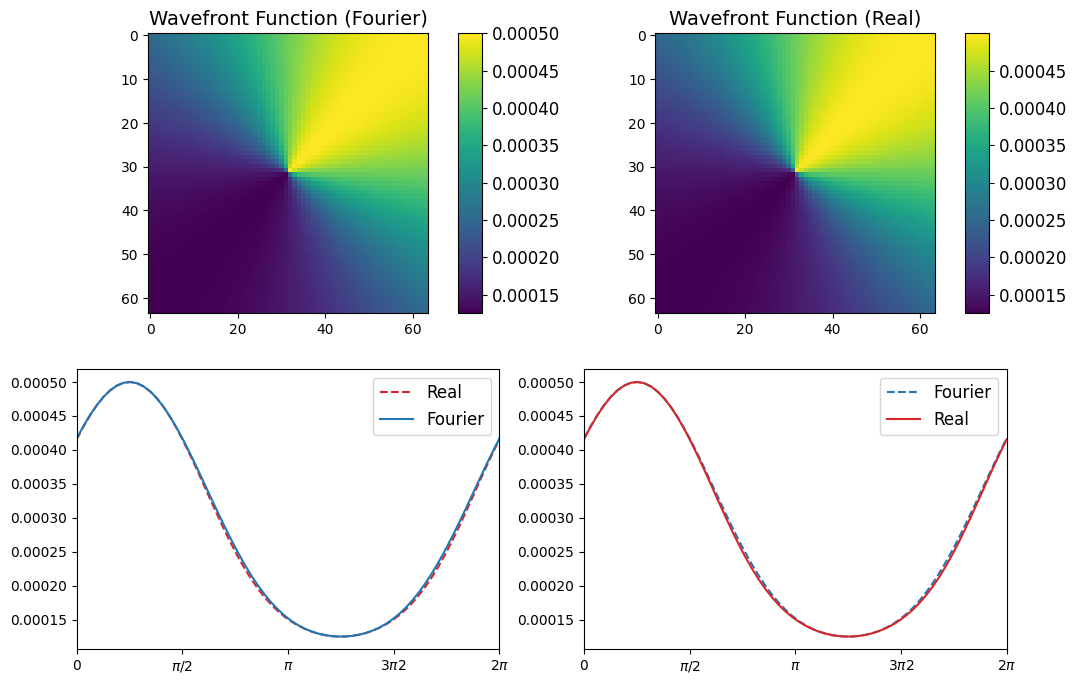

In [8]:
R = 0.005 # Radius to center [m].
v0, v1 = 1500.0, 1600.0 # Background SoS & SoS in tissue [m/s].
r = 0.003 # Distance to center [m].
phi = np.pi/4 # Angle to center [rad].
C0 = (1-v0/v1) * R * (1 - (r**2)/(4*R**2))
C1 = (1-v0/v1) * r 
C2 = (1-v0/v1) * r**2 / (4*R) # C0 - (1-v0/v1) * np.sqrt(R**2-r**2)
print(C0, C1, C2)
w_fourier = wavefront_fourier(C0, C1, phi, C2, phi)
w_real = wavefront_real(R, r, phi, v0, v1)

fig = plt.figure(figsize=(12, 8))
ax1 = plt.subplot(2,2,1)
plt.imshow(w_fourier(theta2D))
ax1.set_title('Wavefront Function (Fourier)', fontsize=14)
cax = fig.add_axes([ax1.get_position().x1+0.025, ax1.get_position().y0, 0.02, ax1.get_position().height])
cb = plt.colorbar(cax=cax)
cb.ax.tick_params(labelsize=10)
plt.tick_params(labelsize=12)

ax3 = plt.subplot(2,2,3)
plt.plot(theta1D, w_real(theta1D), color='tab:red', label='Real', linestyle='--')
plt.plot(theta1D, w_fourier(theta1D), color='tab:blue', label='Fourier')
ax3.legend(fontsize=12)
ax3.set_xticks([0, 0.5*np.pi, np.pi, 1.5*np.pi, 2*np.pi])
ax3.set_xticklabels(['0','$\pi$/2','$\pi$','$3\pi$2','2$\pi$'])
ax3.set_xlim([0,2*np.pi])

ax2 = plt.subplot(2,2,2)
plt.imshow(w_real(theta2D))
ax2.set_title('Wavefront Function (Real)', fontsize=14)
cax = fig.add_axes([ax2.get_position().x1+0.025, ax2.get_position().y0, 0.02, ax2.get_position().height])
cb = plt.colorbar(cax=cax)
cb.ax.tick_params(labelsize=10)
plt.tick_params(labelsize=12)

ax4 = plt.subplot(2,2,4)
plt.plot(theta1D, w_fourier(theta1D), color='tab:blue', label='Fourier', linestyle='--')
plt.plot(theta1D, w_real(theta1D), color='tab:red', label='Real')
ax4.legend(fontsize=12)
ax4.set_xticks([0, 0.5*np.pi, np.pi, 1.5*np.pi, 2*np.pi])
ax4.set_xticklabels(['0','$\pi$/2','$\pi$','$3\pi$2','2$\pi$'])
ax4.set_xlim([0,2*np.pi])


plt.savefig('../figures/wavefront.jpg', bbox_inches='tight')

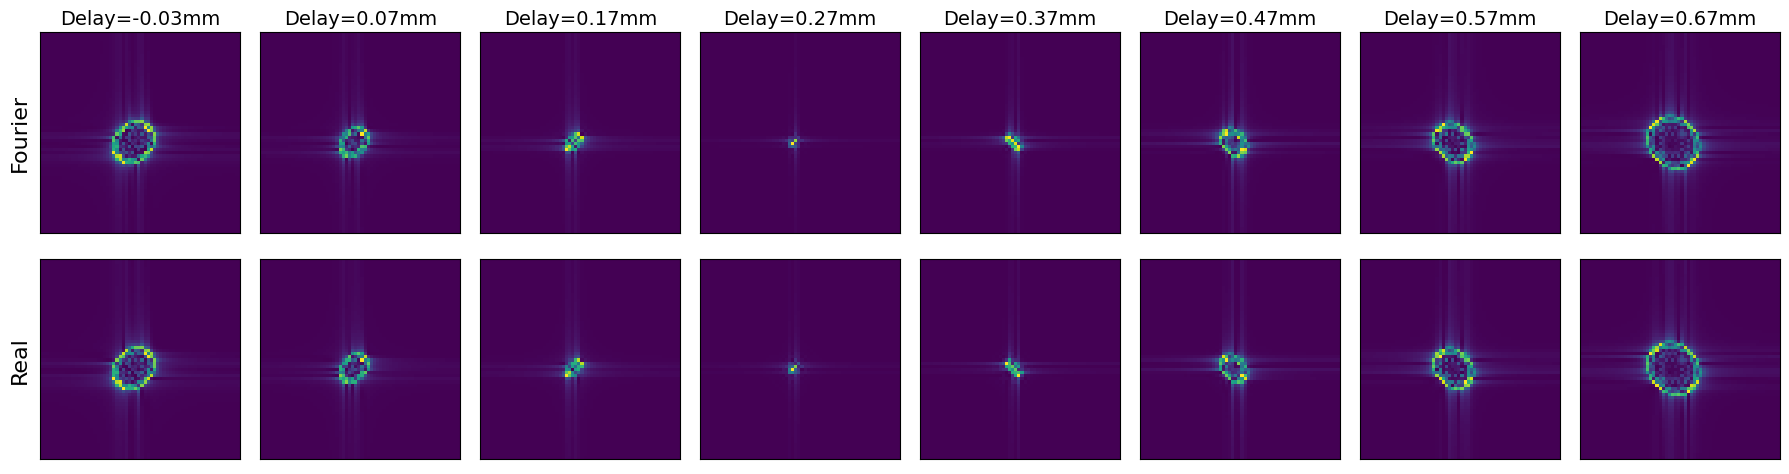

In [9]:
n_delays = 8
delay_step, offset = 1e-4, (1-v0/v1) * R * 7/8
delays = torch.linspace(-(n_delays/2-1), n_delays/2, n_delays) * delay_step + offset
print(delays)

fig = plt.figure(figsize=(18, 5))
for i, (w, label) in enumerate(zip([w_fourier, w_real], ['Fourier', 'Real'])):
    psfs = []
    for j, delay in enumerate(delays):
        psfs.append(PSF(theta2D, k2D, w, delay))
        plt.subplot(2,8,j+1+8*i)
        plt.imshow(psfs[j])
        plt.xticks([])
        plt.yticks([])
        if i == 0:
            plt.title('Delay={:.2f}mm'.format(delays[j]*1e3), fontsize=14)
        if j == 0:
            plt.ylabel(label, fontsize=16)

plt.tight_layout()
plt.savefig('../figures/psfs.jpg', bbox_inches='tight')

In [11]:
plt.imsave('../figures/psf.jpg', psfs[-1])

In [28]:
phi = torch.linspace(0, 2*np.pi, 100)
x = torch.tensor(1)
y = torch.tensor(0)
phi = torch.arctan2(x, y) / np.pi - 1
print(phi)

tensor(-0.5000)
